# Finetuned Model Testing

This notebook tests our finetuned model from Hugging Face across different recipe categories:
1. Simple recipes
2. High GI recipes
3. Low GI recipes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from agents.gi_agent_roberta_finetuned import GIAnalysisAgentRoBERTaFinetuned
from agents.gi_agent_roberta_finetuned_2 import GIAnalysisAgentRoBERTaFinetuned2
from agents.gi_grader_agent import GIGraderAgent
from test_data.simple.simple_recipes import SIMPLE_RECIPES
from test_data.high_gi.high_gi_recipes import HIGH_GI_RECIPES
from test_data.low_gi.low_gi_recipes import LOW_GI_RECIPES
import json
from typing import List, Dict, Any
from datetime import datetime
import os

## Setup Results Directory

In [2]:
# Create timestamp for this test run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_dir = f'test_results/finetuned/{timestamp}'
plots_dir = f'{results_dir}/plots'
data_dir = f'{results_dir}/data'

# Create directories if they don't exist
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

print(f"Results will be saved in: {results_dir}")

Results will be saved in: test_results/finetuned/20250527_112044


## Initialize Agents

In [3]:
# Initialize agents
gi_agent = GIAnalysisAgentRoBERTaFinetuned2()
grader_agent = GIGraderAgent()

Successfully loaded food data with 5000 entries


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Test Function

In [10]:
def test_category(recipes: List[Dict[str, Any]], category_name: str) -> pd.DataFrame:
    """Test a category of recipes and return results"""
    results = []
    
    for recipe in recipes:
        # Get our prediction
        our_result = gi_agent.process([recipe])
        if 'error' in our_result:
            print(f"Error processing {recipe['title']}: {our_result['error']}")
            continue
            
        our_prediction = our_result['glycemic_load']
        
        # Get expert grading
        grade_result = grader_agent.grade_prediction(recipe, our_prediction)
        
        # Store results
        results.append({
            'recipe': recipe['title'],
            'category': category_name,
            'our_prediction': our_prediction,
            'expert_assessment': grade_result['assessed_gi'],
            'prediction_difference': grade_result['prediction_difference']
        })
    
    return pd.DataFrame(results)

## Run Tests and Calculate Metrics

In [11]:
simple_results = test_category(SIMPLE_RECIPES[:1], "Simple")
simple_results


Debug - Ingredient: brown rice
Debug - GI Value: 25.0
Debug - Carb Content: 77.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 184.8
Debug - Ingredient Load: 46.2

Debug - Ingredient: steamed vegetables
Debug - GI Value: 15.0
Debug - Carb Content: 4.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 9.6
Debug - Ingredient Load: 1.44

Debug - Ingredient: olive oil
Debug - GI Value: 15.0
Debug - Carb Content: 0.0
Debug - Original Quantity: 1 tbsp
Debug - Converted Quantity (g): 15.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Ingredient: soy sauce
Debug - GI Value: 15.0
Debug - Carb Content: 4.7
Debug - Original Quantity: 1 tsp
Debug - Converted Quantity (g): 5.0
Debug - Actual Carbs (g): 0.235
Debug - Ingredient Load: 0.03525

Debug - Total Glycemic Load: 47.67525


,recipe,category,our_prediction,expert_assessment,prediction_difference
0,Basic Brown Rice Bowl,Simple,47.67525,50.0,2.32475


In [6]:
# Test each category
simple_results = test_category(SIMPLE_RECIPES, "Simple")
high_gi_results = test_category(HIGH_GI_RECIPES, "High GI")
low_gi_results = test_category(LOW_GI_RECIPES, "Low GI")

# Combine results
all_results = pd.concat([simple_results, high_gi_results, low_gi_results])

# Calculate RMSE for each recipe
all_results['rmse'] = all_results['prediction_difference'] ** 2

# Display results
all_results


Debug - Ingredient: brown rice
Debug - GI Value: 25.0
Debug - Carb Content: 77.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 184.8
Debug - Ingredient Load: 46.2

Debug - Ingredient: steamed vegetables
Debug - GI Value: 15.0
Debug - Carb Content: 4.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 9.6
Debug - Ingredient Load: 1.44

Debug - Ingredient: olive oil
Debug - GI Value: 15.0
Debug - Carb Content: 0.0
Debug - Original Quantity: 1 tbsp
Debug - Converted Quantity (g): 15.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Ingredient: soy sauce
Debug - GI Value: 15.0
Debug - Carb Content: 4.7
Debug - Original Quantity: 1 tsp
Debug - Converted Quantity (g): 5.0
Debug - Actual Carbs (g): 0.235
Debug - Ingredient Load: 0.03525

Debug - Total Glycemic Load: 47.67525

Debug - Ingredient: red lentils
Debug - GI Value: 15.0
Debug - Carb Content: 60.0
Debug - Original Qu

,recipe,category,our_prediction,expert_assessment,prediction_difference,rmse
0,Basic Brown Rice Bowl,Simple,0.476752,0.5000,2.32475,5.404463
1,Simple Lentil Soup,Simple,0.234105,0.2800,4.58950,21.063510
2,Basic Quinoa Salad,Simple,0.126312,0.4650,33.86880,1147.095613
3,Simple Tofu Stir Fry,Simple,0.505815,0.4750,3.08150,9.495642
4,Basic Bean Bowl,Simple,0.562035,0.4500,11.20350,125.518412
0,White Rice and Sweet Potato Bowl,High GI,0.997202,0.8735,12.37015,153.020611
1,Pasta with White Sauce,High GI,0.684600,0.3800,30.46000,927.811600
2,Mashed Potatoes with Gravy,High GI,0.035220,0.6650,62.97800,3966.228484
3,White Bread Sandwich,High GI,0.003420,0.7375,73.40800,5388.734464
4,Breakfast Cereal Bowl,High GI,0.668145,0.6800,1.18550,1.405410


## Visualize Results

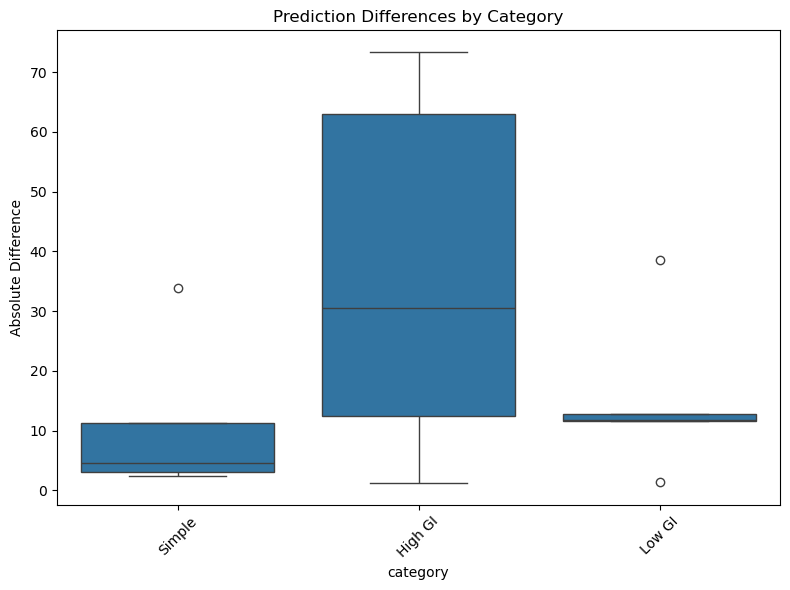

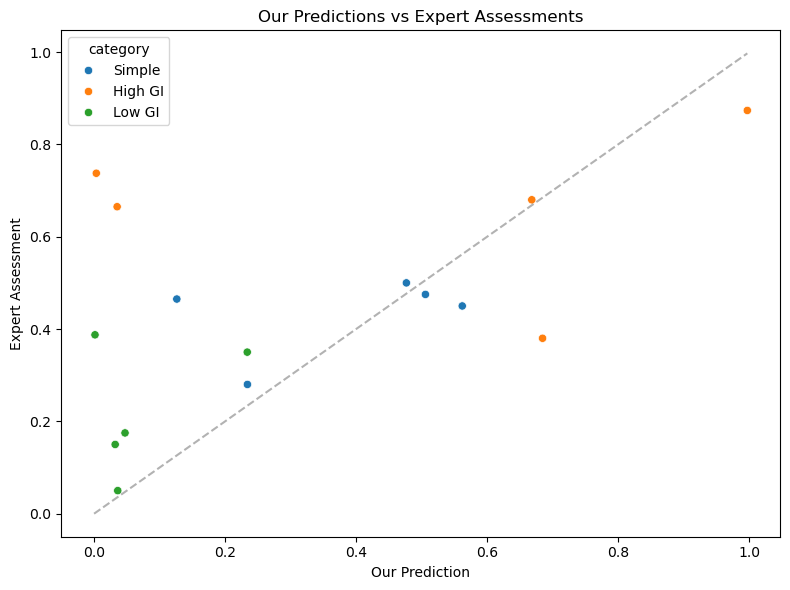

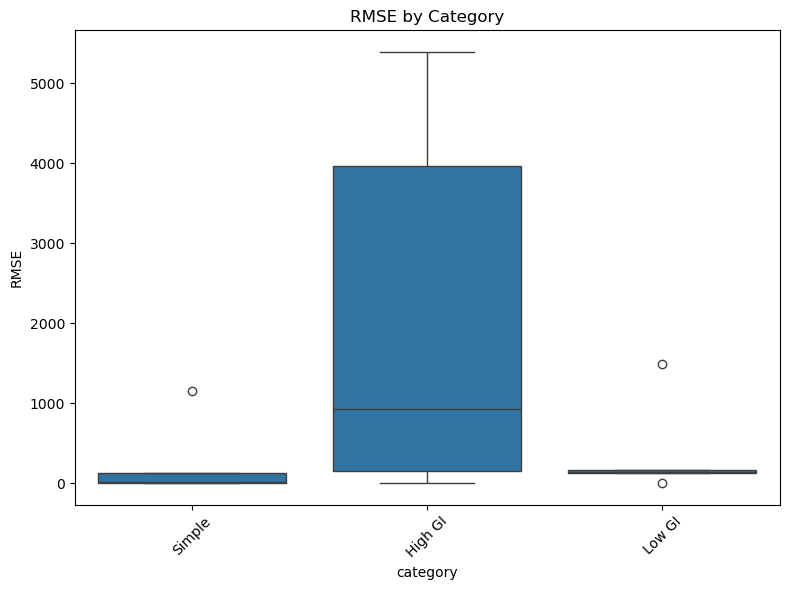

In [12]:
# --- Plot 1: Box plot of prediction differences by category ---
plt.figure(figsize=(8, 6))
sns.boxplot(x='category', y='prediction_difference', data=all_results)
plt.title('Prediction Differences by Category')
plt.xticks(rotation=45)
plt.ylabel('Absolute Difference')
plt.tight_layout()
plt.savefig(f'{plots_dir}/box_plot_prediction_difference.png')
plt.show()

# --- Plot 2: Scatter plot of predictions vs expert assessments ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=all_results, x='our_prediction', y='expert_assessment', hue='category')
max_val = max(all_results['our_prediction'].max(), all_results['expert_assessment'].max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)  # Diagonal line
plt.title('Our Predictions vs Expert Assessments')
plt.xlabel('Our Prediction')
plt.ylabel('Expert Assessment')
plt.tight_layout()
plt.savefig(f'{plots_dir}/scatter_plot_predictions_vs_experts.png')
plt.show()

# --- Plot 3: Box plot of RMSE by category ---
plt.figure(figsize=(8, 6))
sns.boxplot(x='category', y='rmse', data=all_results)
plt.title('RMSE by Category')
plt.xticks(rotation=45)
plt.ylabel('RMSE')
plt.tight_layout()
plt.savefig(f'{plots_dir}/box_plot_rmse.png')
plt.show()

## Analysis

In [8]:
print("\nOverall Statistics:")
print("=================")
print(f"Total recipes tested: {len(all_results)}")
print(f"Mean prediction difference: {all_results['prediction_difference'].mean():.2f}")
print(f"Root Mean Square Error (RMSE): {np.sqrt(all_results['rmse'].mean()):.2f}")
print(f"Standard deviation: {all_results['prediction_difference'].std():.2f}")
print(f"Max difference: {all_results['prediction_difference'].max():.2f}")
print(f"Min difference: {all_results['prediction_difference'].min():.2f}")

print("\nCategory-wise Statistics:")
print("======================")
for category in ['Simple', 'High GI', 'Low GI']:
    cat_results = all_results[all_results['category'] == category]
    print(f"\n{category}:")
    print(f"Number of recipes: {len(cat_results)}")
    print(f"Mean difference: {cat_results['prediction_difference'].mean():.2f}")
    print(f"RMSE: {np.sqrt(cat_results['rmse'].mean()):.2f}")
    print(f"Standard deviation: {cat_results['prediction_difference'].std():.2f}")


Overall Statistics:
Total recipes tested: 15
Mean prediction difference: 20.78
Root Mean Square Error (RMSE): 30.19
Standard deviation: 22.68
Max difference: 73.41
Min difference: 1.19

Category-wise Statistics:

Simple:
Number of recipes: 5
Mean difference: 11.01
RMSE: 16.18
Standard deviation: 13.25

High GI:
Number of recipes: 5
Mean difference: 36.08
RMSE: 45.69
Standard deviation: 31.34

Low GI:
Number of recipes: 5
Mean difference: 15.23
RMSE: 19.64
Standard deviation: 13.87


## Export Results

In [9]:
# Save detailed results to CSV
all_results.to_csv(f'{data_dir}/finetuned_model_results.csv', index=False)

# Save summary statistics
summary_stats = {
    'overall': {
        'total_recipes': len(all_results),
        'mean_difference': all_results['prediction_difference'].mean(),
        'rmse': np.sqrt(all_results['rmse'].mean()),
        'std_difference': all_results['prediction_difference'].std(),
        'max_difference': all_results['prediction_difference'].max(),
        'min_difference': all_results['prediction_difference'].min()
    },
    'by_category': {
        category: {
            'count': len(all_results[all_results['category'] == category]),
            'mean_difference': all_results[all_results['category'] == category]['prediction_difference'].mean(),
            'rmse': np.sqrt(all_results[all_results['category'] == category]['rmse'].mean()),
            'std_difference': all_results[all_results['category'] == category]['prediction_difference'].std()
        }
        for category in ['Simple', 'High GI', 'Low GI']
    }
}

with open(f'{data_dir}/summary_stats.json', 'w') as f:
    json.dump(summary_stats, f, indent=4)

print(f"\nResults have been saved to {results_dir}")


Results have been saved to test_results/finetuned/20250527_112044
